# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в
прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут
заинтересовать покупателей этой возрастной группы и контролировать добросовестность кассиров при продаже алкоголя.
Строится модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий
людей с указанием возраста.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

### Загрузка данных

In [3]:
# Целевые классы
labels = pd.read_csv('/datasets/faces/labels.csv')

# Изображения (приводим нормировку с диапазон 0 - 1)
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

labels.info()

Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


### График распределения возраста

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

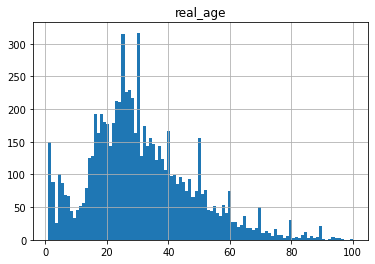

In [6]:
labels.hist(bins=100)

In [7]:
# Анализ выбросов
labels['real_age'].value_counts().sort_index().head(50).to_dict()

{1: 149,
 2: 88,
 3: 25,
 4: 101,
 5: 87,
 6: 68,
 7: 67,
 8: 44,
 9: 34,
 10: 45,
 11: 51,
 12: 56,
 13: 79,
 14: 125,
 15: 128,
 16: 193,
 17: 163,
 18: 193,
 19: 180,
 20: 178,
 21: 143,
 22: 179,
 23: 213,
 24: 211,
 25: 315,
 26: 226,
 27: 229,
 28: 217,
 29: 164,
 30: 317,
 31: 129,
 32: 174,
 33: 144,
 34: 156,
 35: 147,
 36: 122,
 37: 144,
 38: 124,
 39: 107,
 40: 167,
 41: 98,
 42: 99,
 43: 85,
 44: 96,
 45: 88,
 46: 74,
 47: 93,
 48: 66,
 49: 74,
 50: 156}

### Анализ изображений

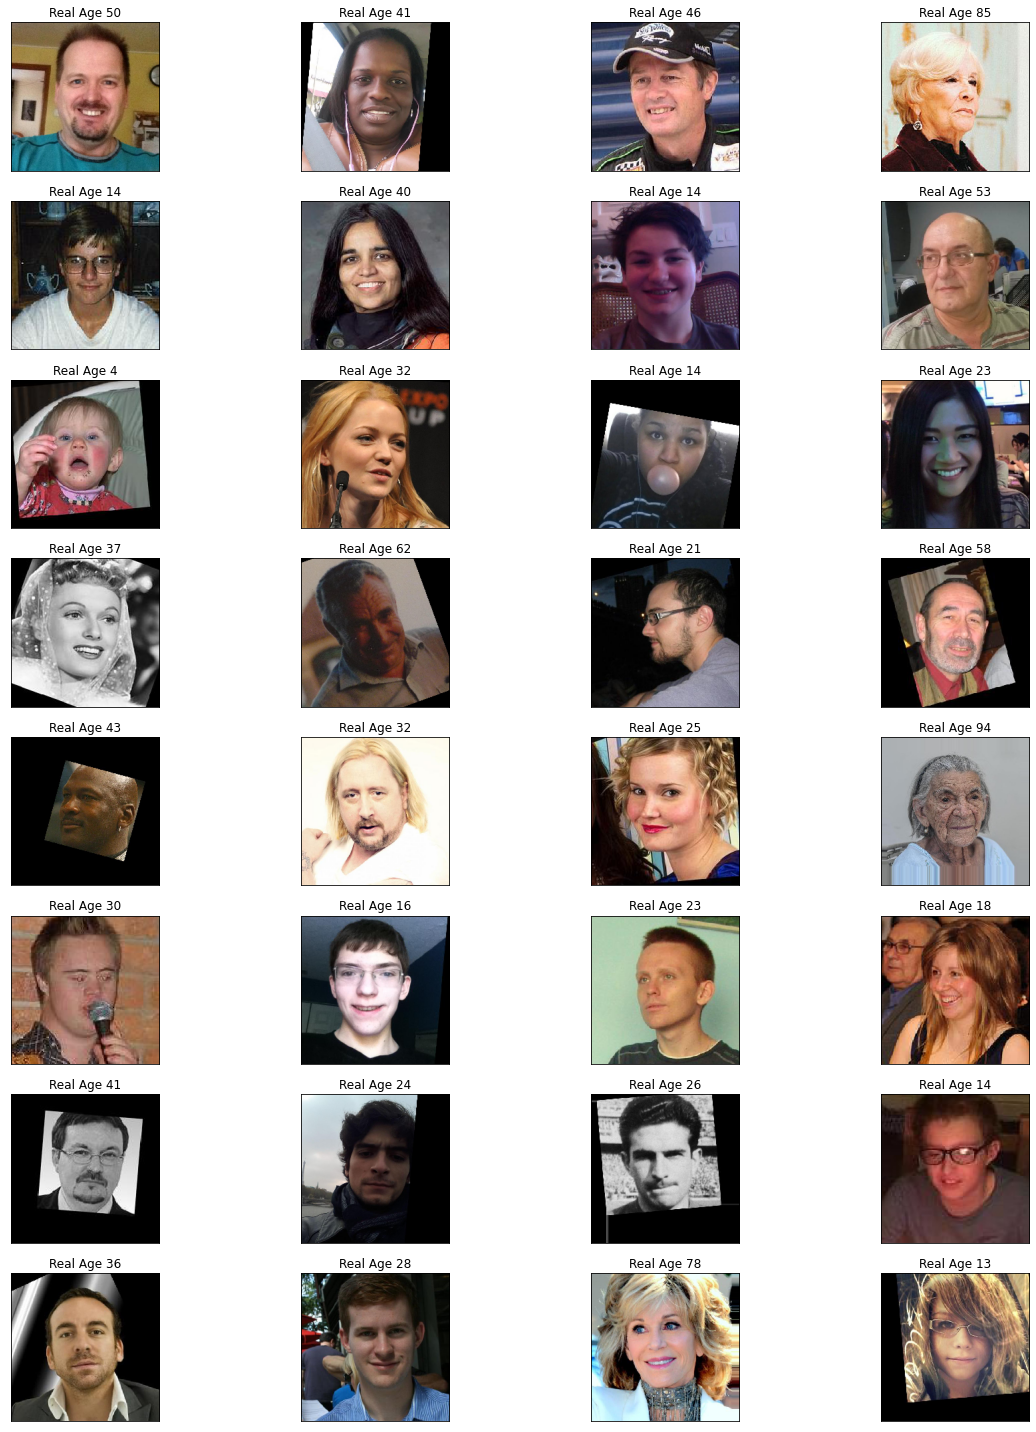

In [8]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(20,20))
for i in range(32):
    ax = fig.add_subplot(8, 4, i+1)
    plt.imshow(features[i])
    ax.title.set_text('Real Age {:.0f}'.format(target[i]))
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

/tmp/ipykernel_93/481736629.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(1, 1, 1)


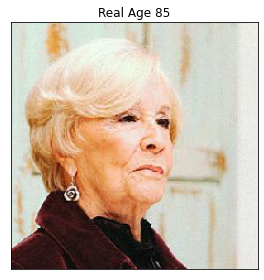

In [24]:
fig.add_subplot(1, 1, 1)
plt.imshow(features[3])
plt.xticks([])
plt.yticks([])
plt.title('Real Age {:.0f}'.format(target[3]))
plt.tight_layout()

### Выводы

- График гистограммы возрастов похож на нормальное распределение
- Выделяются выбросы данных. Особенно проявляется до 7 лет, 25 лет, 30 лет, 50 лет. Т.е в этих возрастах наблюдается существенно больше данных, что может сказаться на обучении и "перекосе" обучающейся модели
- Задача относится к задаче регрессии (нужно определить возраст (число) по изображению)
- Визуально валидация нескольких примеров подтверждает корректность реального возраста в исходных данных
- Можно предположить, что пиковые выбросы на гистограмме нужно не учитывать, т.к. там много ошибок. Возможно стоит обучить модель сначала на данных без выбросов, потом "скормить" ей выбромы и посмотреть, какой возраст определится - явные расхождения отбросить
- Сами изображения через генератор маштабированы к 224 на 224 px, изображения полноцеветные (RGB)

## Обучение модели

```python

import pandas as pd
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    # Целевые классы
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    directory = os.path.join(path, 'final_files/')
    # Изображения (приводим нормировку 0 - 1, добавляем доп.данные путем аугментации, выделяем 25% на валидацию)
    datagen = ImageDataGenerator(rescale=1. / 255,
                                 horizontal_flip=True,
                                 validation_split=0.25)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow


def load_test(path):
    # Целевые классы
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    directory = os.path.join(path, 'final_files/')
    # Изображения (приводим нормировку 0 - 1, добавляем доп.данные путем аугментации, выделяем 25% на валидацию)
    datagen = ImageDataGenerator(rescale=1. / 255,
                                 validation_split=0.25)
    val_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return val_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    optimizer = Adam(lr=0.001)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_datagen_flow, valid_datagen_flow, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None, verbose=2):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(valid_datagen_flow)

    model.fit(train_datagen_flow,
              validation_data=valid_datagen_flow,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=verbose,
              epochs=epochs)

    return model

```

2022-07-09 03:18:47.986777: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-07-09 03:18:48.192451: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-07-09 03:18:52.766879: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-09 03:18:53.388616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-09 03:18:53.388691: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-09 03:18:53.388722: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-09 03:18:53.455630: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-09 03:18:53.488796: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-07-09 03:18:53.814869: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-07-09 03:18:53.853131: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-07-09 03:18:53.853232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-07-09 03:18:53.857678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-09 03:18:53.858063: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-07-09 03:18:53.907751: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-07-09 03:18:53.910491: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c4030 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-09 03:18:53.910519: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-07-09 03:18:54.142702: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564a050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-07-09 03:18:54.142742: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-07-09 03:18:54.145101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-09 03:18:54.145154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-09 03:18:54.145163: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-09 03:18:54.145187: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-09 03:18:54.145196: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-07-09 03:18:54.145205: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-07-09 03:18:54.145214: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-07-09 03:18:54.145222: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-07-09 03:18:54.149464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-09 03:18:54.151213: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-09 03:18:57.520896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-07-09 03:18:57.520946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-07-09 03:18:57.520954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-07-09 03:18:57.528671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15
2022-07-09 03:19:22.329645: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-09 03:19:24.607942: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 66s - loss: 243.3439 - mae: 11.8413 - val_loss: 539.1910 - val_mae: 18.1623  
Epoch 2/15  
178/178 - 38s - loss: 164.3812 - mae: 9.8715 - val_loss: 284.1976 - val_mae: 12.9059
Epoch 3/15  
178/178 - 38s - loss: 136.7282 - mae: 8.9163 - val_loss: 398.3628 - val_mae: 14.9777  
Epoch 4/15  
178/178 - 38s - loss: 115.3353 - mae: 8.1736 - val_loss: 260.0380 - val_mae: 11.9810  
Epoch 5/15  
178/178 - 38s - loss: 102.7253 - mae: 7.6954 - val_loss: 133.4190 - val_mae: 8.7901  
Epoch 6/15  
178/178 - 38s - loss: 90.9552 - mae: 7.2958 - val_loss: 124.8364 - val_mae: 8.3959  
Epoch 7/15  
178/178 - 38s - loss: 79.5218 - mae: 6.7991 - val_loss: 110.2681 - val_mae: 7.9679  
Epoch 8/15  
178/178 - 38s - loss: 71.1908 - mae: 6.4506 - val_loss: 119.2972 - val_mae: 8.1712  
Epoch 9/15  
178/178 - 38s - loss: 59.0400 - mae: 5.9355 - val_loss: 110.6481 - val_mae: 7.9655  
Epoch 10/15  
178/178 - 38s - loss: 50.3834 - mae: 5.4588 - val_loss: 142.2839 - val_mae: 9.0019  
Epoch 11/15  
178/178 - 38s - loss: 43.5869 - mae: 5.0890 - val_loss: 117.8403 - val_mae: 8.2104  
Epoch 12/15  
178/178 - 38s - loss: 38.4892 - mae: 4.7741 - val_loss: 179.9000 - val_mae: 10.1533  
Epoch 13/15  
178/178 - 38s - loss: 34.2386 - mae: 4.5028 - val_loss: 105.3200 - val_mae: 7.9408  
Epoch 14/15  
178/178 - 38s - loss: 28.5714 - mae: 4.1116 - val_loss: 169.2018 - val_mae: 9.3965
Epoch 15/15  
178/178 - 38s - loss: 25.7441 - mae: 3.8819 - val_loss: 105.8248 - val_mae: 7.9684  
WARNING:tensorflow:sample_weight modes were coerced from    
  ...
    to  
  ['...']
60/60 - 9s - loss: 105.8248 - mae: 7.9684  
Test MAE: 7.9684

## Анализ обученной модели

- Построили модели регрессии
- В качестве архитектуры сети использовали ResNet с последним слоем в 1 нейрон с функцией активации relu
- Для оптимизации модели использовали предобученные на ImageNet стартовы веса
- Для дополнительного набора данных обучения использовали аугментацию с горизонтальным флипом
- В качестве функции потерь использовалась MSE, а метрикой качества модели - MAE
- Оптимизатором модели являлся adam
- Целевая метрика качества MAE на тестовых данных оказалась ниже 8

